# Feedforward Neural Networks

This Jupyter notebook accompanies the blog post on Feedforward Neural Networks

First, we will import the dependencies - **numpy**, the python linear algebra library, **pandas** to load and preprocess the input data and **matplotlib** for visualisation purposes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

We are going to be using the same datasets as with the linear and logistic regression models - to provide a comparison. The code for pre-processing the data is as follows, go to the <a href="https://github.com/mukul-rathi/blogPost-tutorials/blob/master/LinearLogisticRegression/LinearLogisticRegression.ipynb"> Linear/Logistic Regression notebook </a> for a more detailed explanation of the code.

<p> First, the house dataset - this is the dataset we used for linear regression. </p>

In [2]:
house_dataset = pd.read_csv("../LinearLogisticRegression/boston-housing-dataset/train.csv")
house_dataset.drop("ID", axis=1, inplace=True)
house_dataset = house_dataset.reindex(np.random.permutation(house_dataset.index))
#normalise the input features - this ensures they are all in the same range 0-1. 
house_dataset.loc[:, house_dataset.columns!="medv"] -= house_dataset.loc[:, house_dataset.columns!="medv"].mean()
house_dataset.loc[:, house_dataset.columns!="medv"] /= house_dataset.loc[:, house_dataset.columns!="medv"].std()

#transpose to get correct dimensions
X_lin_train = house_dataset.loc[:house_dataset.shape[0]*4//5, house_dataset.columns!="medv"].as_matrix().T 
Y_lin_train = house_dataset.loc[:house_dataset.shape[0]*4//5, ["medv"]].as_matrix().T

X_lin_test = house_dataset.loc[house_dataset.shape[0]*4//5:, house_dataset.columns!="medv"].as_matrix().T 
Y_lin_test = house_dataset.loc[house_dataset.shape[0]*4//5:, ["medv"]].as_matrix().T


Next we will import the breast cancer dataset - used for logistic regression

In [3]:
cancer_dataset = pd.read_csv("../LinearLogisticRegression/breast-cancer-dataset/data.csv")
cancer_dataset.drop(["id",'Unnamed: 32'], axis=1, inplace=True)
cancer_dataset["diagnosis"] = cancer_dataset["diagnosis"].apply(lambda x: 1 if (x=="M") else 0)
#shuffle data
cancer_dataset = cancer_dataset.reindex(np.random.permutation(cancer_dataset.index))

#normalise the input features - this ensures they are all in the same range 0-1. 
cancer_dataset.loc[:, cancer_dataset.columns!="diagnosis"] -= cancer_dataset.loc[:, cancer_dataset.columns!="diagnosis"].mean()
cancer_dataset.loc[:, cancer_dataset.columns!="diagnosis"] /= cancer_dataset.loc[:, cancer_dataset.columns!="diagnosis"].std()

X_log_train = cancer_dataset.loc[:cancer_dataset.shape[0]*4//5, cancer_dataset.columns!="diagnosis"].as_matrix().T 
Y_log_train = cancer_dataset.loc[:cancer_dataset.shape[0]*4//5, ["diagnosis"]].as_matrix().T 

X_log_test = cancer_dataset.loc[cancer_dataset.shape[0]*4//5:, cancer_dataset.columns!="diagnosis"].as_matrix().T 
Y_log_test = cancer_dataset.loc[cancer_dataset.shape[0]*4//5:, ["diagnosis"]].as_matrix().T 



# Creating the neural network:

Having preprocessed our data into matrices, it is now time to create the feedforward neural network. 

First we need to initialise parameters: the weights and biases for each layer.

The weights for layer *$l$* are stored in *$ W^{(l)}$*, a *$n_l$ x $n_{(l-1)}$* matrix, where *$n_l$* is the number of units in layer *$l$*. 
We  initialise the weights randomly from a Gaussian distribution ($\mu=0, \sigma =1$) to break symmetry, and multiply by 0.001 to ensure weights aren't too large.

The biases for layer *$l$* are stored in *$ b^{(l)}$*, which is a *$n_l$ x 1* matrix.

In [4]:
def initialise_parameters(layers_units):
    parameters = {}            # create a dictionary containing the parameters
    for l in range(1, len(layers_units)):
        parameters['W' + str(l)] = 0.001* np.random.randn(layers_units[l],layers_units[l-1])
        parameters['b' + str(l)] = np.zeros((layers_units[l],1))
    return parameters

The activation function $g(z)$ we will be using is the ReLU function $g(z) = max(0,z)$ in the hidden layers.

<br> The only difference in the neural net between regression and classification is the final layer - whether we use the sigmoid function in the final layer, depending on whether we want to do regression or classification. 

NB: Although the ReLU function is technically non-differentiable when $z=0$, in practice we can set the derivative=0 at $z=0$.

In [5]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def relu(z, deriv = False):
    if(deriv):
        return z>0
    else:
        return np.multiply(z, z>0)

We can now write the code for the forward propagation step.

In each layer $l$ , we matrix multiply the output of the previous layer $A^{(l-1)}$  by a weight matrix $W^{(l)}$ and then add a bias term $b^{(l)}$. We then take the result $Z^{(l)}$ and apply the activation function $g(z)$ to it to get the output $A^{(l)}$. $L$ = number of layers.
The equations are thus:
$$Z^{(l)}=W^{(l)}A^{(l-1)}$$
$$A^{(l)}=g(Z^{(l)})$$


In [6]:
def forward_propagation(X,parameters,linear):
    cache = {}
    L = len(parameters)//2 #final layer
    cache["A0"] = X #ease of notation since input = layer 0
    for l in range(1, L):
        cache['Z' + str(l)] = np.dot(parameters['W' + str(l)],cache['A' + str(l-1)]) + parameters['b' + str(l)]
        cache['A' + str(l)] = relu(cache['Z' + str(l)])
    #final layer
    cache['Z' + str(L)] = np.dot(parameters['W' + str(L)],cache['A' + str(L-1)]) + parameters['b' + str(L)]
    cache['A' + str(L)] =cache['Z' + str(L)] if linear else sigmoid(cache['Z' + str(L)])
    return cache 

Next we can compute the loss function - this is the objective function the neural network will aim to minimise during training:

$m$ = number of training examples, $(x^{(i)},y^{(i)})$ is the $i^{th}$ training example.
<br> For regression: 
$$ J(W^{(1)}, b^{(1)},...) = \frac{1}{2m} \sum_{i=1}^{m} (a^{(L) (i)} - y^{(i)})^2 $$


For classification: 

$$J(W^{(1)}, b^{(1)},...) = -\frac{1}{m} \sum\limits_{i = 1}^{m} y^{(i)}\log\left(a^{(L) (i)}\right) + (1-y^{(i)})\log\left(1- a^{(L)(i)}\right) $$



In [7]:
def cost_function(AL,Y, linear):
    m = Y.shape[1]
    if linear:
        cost = (1/(2*m))*(np.sum(np.square(AL-Y)))
    else:
        cost = (-1/m)*( np.sum(np.multiply(Y,np.log(AL))) + np.sum(np.multiply((1-Y),np.log(1-AL))))
    return cost

Now we will code the backpropagation algorithm. This will enable us to calculate the partial derivative of the cost function with respect to each of the weights and biases in each of the layers of the network. The equations can be derived using the multivariable chain rule and are the same for both regression and classification:
$$\frac{\partial \mathcal{J} }{\partial Z^{(L)}} = A^{(L)} - Y$$ 


$$ \frac{\partial \mathcal{J} }{\partial W^{(l)}} = \frac{1}{m}\frac{\partial \mathcal{J} }{\partial Z^{(l)}} A^{(l-1) T} $$

$$ \frac{\partial \mathcal{J} }{\partial b^{(l)}} = \frac{1}{m} \sum_{i = 1}^{m} \frac{\partial \mathcal{J} }{\partial Z^{(l)(i)}}$$

$$ \frac{\partial \mathcal{J} }{\partial A^{(l-1)}} = W^{(l) T} \frac{\partial \mathcal{J} }{\partial Z^{(l)}} $$
$$ \frac{\partial \mathcal{J} }{\partial Z^{(l-1)}} = \frac{\partial \mathcal{J} }{\partial A^{(l-1)}}*g^{'}(Z^{(l-1)})$$




In [8]:
def backpropagation(cache,Y,parameters):
    L = len(parameters)//2 
    m = Y.shape[1]
    grads = {}
    grads["dZ" + str(L)]= cache["A" + str(L)] - Y
    grads["dW" + str(L)]= (1/m)*np.dot(grads["dZ" + str(L)],cache["A" + str(L-1)].T) 
    grads["db" + str(L)]= (1/m)*np.sum(grads["dZ" + str(L)],axis=1,keepdims=True)
    for l in range(L-1,0,-1):
        grads["dA" + str(l)]= np.dot(parameters["W" + str(l+1)].T,grads["dZ" + str(l+1)])
        grads["dZ" + str(l)]= np.multiply(grads["dA" + str(l)], relu(cache["Z" + str(l)], deriv = True))
        grads["dW" + str(l)]= (1/m)*np.dot(grads["dZ" + str(l)],cache["A" + str(l-1)].T) 
        grads["db" + str(l)]= (1/m)*np.sum(grads["dZ" + str(l)],axis=1,keepdims=True)
    return grads

We need to have an evaluation metric to see if the model is actually learning.

For regression, we use Mean Squared Error.

For classification, since the data is skewed, accuracy is not a good metric. So instead we will use the F1 score. The equation for F1 score is as follows:
$$ Precision = \frac{True \space Positive}{True\space Positive + False \space Positive}$$
    
$$Recall = \frac{True \space Positive}{True\space Positive + False \space Negative} $$

$$F1\space Score = \frac{2*Precision*Recall}{Precision + Recall} $$

The F1 score returns a value between 0 and 1 and a higher score means the performance of the model is better.

In [9]:
def F1_score(AL, Y):
    prediction = (AL >= (np.ones_like(AL)/2))
    
    truth_pos = (Y == np.ones_like(Y))
    truth_neg = (Y == np.zeros_like(Y))
    pred_pos = (prediction == np.ones_like(prediction))
    pred_neg = (prediction == np.zeros_like(prediction))

    true_pos = np.sum(np.logical_and(truth_pos,pred_pos))
    if true_pos == 0: #This prevents an undefined computation since precision=recall=0 
        return 0
    false_pos =np.sum(np.logical_and(truth_neg,pred_pos))
    false_neg =np.sum(np.logical_and(truth_pos,pred_neg))
    true_neg =np.sum(np.logical_and(truth_neg,pred_neg))

    precision = true_pos/(true_pos + false_pos)
    recall = (true_pos)/(true_pos + false_neg)
    F1_score = 2*(recall*precision) /(recall + precision)
    return F1_score

In [10]:
def evaluation_metric(AL, Y, linear):
    if linear:
        return cost_function(AL,Y,linear) #MSE for regression
    else:
        return F1_score(AL, Y) #F1 score for classification

Now let's combine the functions created so far to create a model and train it using  gradient descent. 

The update equations for the parameters are as follows:
$$ W^{(l)} = W^{(l)} - \alpha \frac{\partial \mathcal{J} }{\partial W^{(l)}} $$

$$ b^{(l)} = b^{(l)} - \alpha \frac{\partial \mathcal{J} }{\partial b^{(l)}} $$

where $\alpha$ is the learning rate parameter.

In [11]:
def train_model(X_train, Y_train,num_epochs,layers_units,learning_rate, linear):
    train_costs = []
    
    parameters = initialise_parameters(layers_units)
    L = len(layers_units)-1 
    for epoch in range (num_epochs):
        #perform one cycle of forward and backward propagation to get the partial derivatives w.r.t. the weights
        #and biases. Calculate the cost - used to monitor training
        cache = forward_propagation(X_train,parameters,linear)
        cost = cost_function(cache["A" + str(L)],Y_train,linear)
        grads = backpropagation(cache,Y_train,parameters)

        #update the parameters using gradient descent
        for l in range(1,L+1):
            parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate*grads["dW" + str(l)]
            parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate*grads["db" + str(l)]

        #periodically output an update on the current cost and performance on the dev set for visualisation
        train_costs.append(cost)
        if(epoch%(num_epochs//10)==0):
            print("Training the model, epoch: " + str(epoch+1))
            print("Cost after epoch " + str((epoch)) + ": " + str(cost))
    print("Training complete!")
    #return the trained parameters and the visualisation metrics
    return parameters, train_costs

To evaluate the model, we visualise the training set error over the number of iterations. We then output the final value of the evaluation metric for training and test sets.

In [12]:
def evaluate_model(train_costs,parameters,X_train, Y_train, X_test, Y_test, linear):
    #plot the graphs of training set error
    plt.plot(np.squeeze(train_costs))
    plt.ylabel('Cost')
    plt.xlabel('Iterations')
    plt.title("Training Set Error")
    plt.show()
    L = len(parameters)//2
    
    #For train and test sets, perform a step of forward propagation to obtain the trained model's 
    #predictions and evaluate this with an F1 score.
    train_cache = forward_propagation(X_train,parameters,linear)
    train_AL = train_cache["A"+ str(L)]
    if linear: 
         print("The train set MSE is: "+str(evaluation_metric(train_AL,Y_train, linear)))
    else:
        print("The train set F1 score is: "+str(evaluation_metric(train_AL,Y_train, linear)))
    
    test_cache = forward_propagation(X_test,parameters, linear)
    test_AL = test_cache["A"+ str(L)]
    if linear:
                print("The test set MSE is: "+str(evaluation_metric(test_AL,Y_test, linear)))
    else:
        print("The test set F1 score is: "+str(evaluation_metric(test_AL,Y_test, linear)))

We now can write the overall function to run the neural network - this ensures it is easy to run subsequent models by packaging all the functions into one line of code.

In [13]:
def run_model(X_train, Y_train, X_test, Y_test, hyperparameters, linear=True):
    num_epochs = hyperparameters["num_epochs"]
    layers_units = hyperparameters["layers_units"]
    learning_rate = hyperparameters["learning_rate"]
    
    parameters, train_costs = train_model(X_train, Y_train ,num_epochs,layers_units,learning_rate,linear)         
    evaluate_model(train_costs,parameters,X_train, Y_train, X_test, Y_test,linear)

In [14]:
#define the hyperparameters for the model
def create_hyperparameters(X, num_epochs):
    hyperparameters={}
    hyperparameters["num_epochs"] = num_epochs #number of passes through the training set
    hyperparameters["layers_units"] = [X.shape[0], 64, 64,32, 1] #layer 0 is the input layer
    hyperparameters["learning_rate"] = 1e-3
    return hyperparameters

Training the model, epoch: 1
Cost after epoch 0: 317.1803170720049
Training the model, epoch: 101
Cost after epoch 100: 20.39806761100618
Training the model, epoch: 201
Cost after epoch 200: 7.032355284852191
Training the model, epoch: 301
Cost after epoch 300: 5.376387288679558
Training the model, epoch: 401
Cost after epoch 400: 4.366280149491956
Training the model, epoch: 501
Cost after epoch 500: 3.722877431000237
Training the model, epoch: 601
Cost after epoch 600: 3.325948906267952
Training the model, epoch: 701
Cost after epoch 700: 3.0425293025870928
Training the model, epoch: 801
Cost after epoch 800: 2.7836146928966983
Training the model, epoch: 901
Cost after epoch 900: 2.5920008899660942
Training complete!


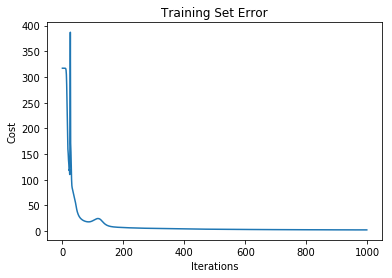

The train set MSE is: 2.47320001814079
The test set MSE is: 12.144280011641133


In [15]:
hyperparameters = create_hyperparameters(X_lin_train, 1000)
run_model(X_lin_train, Y_lin_train, X_lin_test, Y_lin_test,hyperparameters, linear=True)

Training the model, epoch: 1
Cost after epoch 0: 0.6931471805415712
Training the model, epoch: 7001
Cost after epoch 7000: 0.42260983689735593
Training the model, epoch: 14001
Cost after epoch 14000: 0.3875974239952056
Training the model, epoch: 21001
Cost after epoch 21000: 0.36185435291421825
Training the model, epoch: 28001
Cost after epoch 28000: 0.34686309512342506
Training the model, epoch: 35001
Cost after epoch 35000: 0.3333749820469602
Training the model, epoch: 42001
Cost after epoch 42000: 0.3225978118573446


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


Training the model, epoch: 49001
Cost after epoch 49000: nan
Training the model, epoch: 56001
Cost after epoch 56000: nan
Training the model, epoch: 63001
Cost after epoch 63000: nan
Training complete!


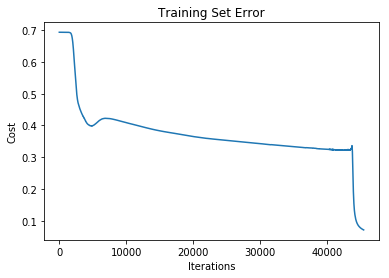

The train set F1 score is: 0.9800796812749003
The test set F1 score is: 0.925925925925926


In [16]:
hyperparameters = create_hyperparameters(X_log_train,75000)
run_model(X_log_train, Y_log_train, X_log_test, Y_log_test,hyperparameters, linear=False)

Comparing with the linear and logistic regression models it is clear that the neural network outperforms these two algorithms. 

**Performance on Test Sets:**

    Linear Regression: MSE of 12.144280011641133 vs 24.35323181847871

    Logistic Regression: F1 score of 0.925925925925926 vs 0.918918918918919

However, what is interesting to note is that the neural net performs much worse on the test set compared to the training set - this is known as **overfitting**. 

In future blog posts, we will look at this issue, as well as looking at techniques that can improve gradient descent for learning.